# Template for analyzing the CLM5-PPE
- Updated Jan 27, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("/glade/u/home/djk2120/ppe_tools")
from ppe_analysis.analysis import *

In [3]:
import panel as pn
import param
pn.extension()

## spin up some extra cores on CASPER

In [4]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [19]:
client.cluster

In [9]:
ds=get_exp('transient',dvs=['GPP','BTRANMN','FCTR'],
          yy=(1995,2014),tape='h1')

In [10]:
ds2=get_exp('transient',dvs=['SOILWATER_10CM','GPP','EFLX_LH_TOT','FCTR'],
          yy=(1995,2014),tape='h0')

In [28]:
p=7
pfts[p]

<xarray.DataArray ()>
array('broadleaf_deciduous_temperate_tree', dtype='<U35')

In [39]:
ds.lapft.sel(pft=p).sum()

<xarray.DataArray 'lapft' ()>
array(6.7683487e+08)

In [58]:
x=amean(ds.GPP.sel(pft=p)).std(dim='year')

In [63]:
la=ds.lapft.sel(pft=p).mean(dim='time')
xx=24*60*60/la.sum()*(la*x).sum(dim='pft').compute()

In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [96]:
pvals=[ds[p].sel(ens=1+np.arange(500)).values.reshape([-1,1]) for p in ds.params.values]
x=np.concatenate(pvals,axis=1)

In [99]:
y=xx.sel(ens=1+np.arange(500)).values

In [100]:
## gaussian process regression
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,normalize_y=True)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x, y);

In [112]:
ypreds=[]
for i in range(32):
    xpred=np.zeros([20,32])+0.5
    xpred[:,i]=np.linspace(0,1,20)
    ypred, sigma = gp.predict(xpred, return_std=True)
    ypreds.append(ypred)

In [117]:
da=xr.DataArray(ypreds,dims=['param','value'])
da['param']=ds.params.values
da['value']=np.linspace(0,1,20)

In [125]:
sortp=np.flip(da.std(dim='value').argsort())

In [ ]:
plt.figure(figsize=[12,16])
for i,param in enumerate(sortp):
    plt.subplot(8,4,i+1)
    plt.plot(np.linspace(0,1,20),da.isel(param=param),label=da.param[param].values)
    plt.ylim([0.05,0.35])
    if i==1:
        plt.title('Influence of PPE on GPP IAV in Broadleaf deciduous trees')
    if (i%4)!=0:
        plt.yticks([0.1,0.2,0.3],'')
    else:
        plt.ylabel('GPP IAV (gC/m2/d)')
    if i<28:
        plt.xticks([0,0.5,1],'')
    else:
        plt.xlabel('normalized parameter value')
    plt.legend()
plt.savefig('gpp_iav.png',bbox_inches='tight')

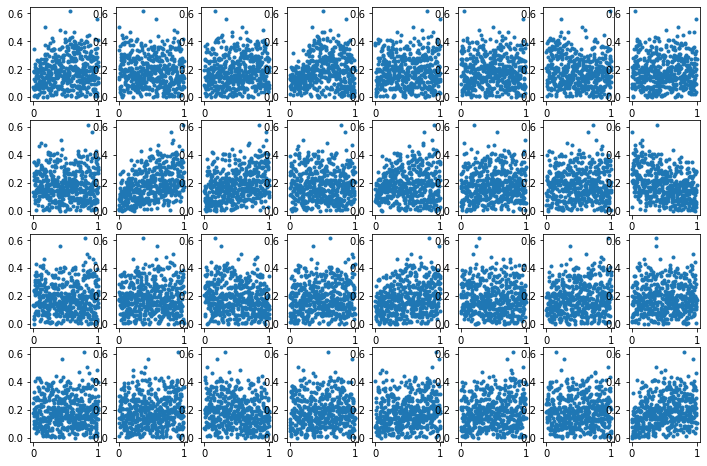

In [72]:
plt.figure(figsize=[12,8])
i=0
for p in ds.params.values:
    i+=1
    plt.subplot(4,8,i)
    plt.plot(ds[p],xx,'.')

In [47]:
x=(1e-9*ds.lapft*ds.GPP).sel(pft=p).sum(dim='pft')
xx=amean(x,cf=24*60*60)

(array([ 37.,  62.,  70., 111., 105.,  69.,  30.,  14.,   1.,   2.]),
 array([1.93800130e-05, 2.15980985e-02, 4.31768170e-02, 6.47555354e-02,
        8.63342539e-02, 1.07912972e-01, 1.29491691e-01, 1.51070409e-01,
        1.72649128e-01, 1.94227846e-01, 2.15806565e-01]),
 <BarContainer object of 10 artists>)

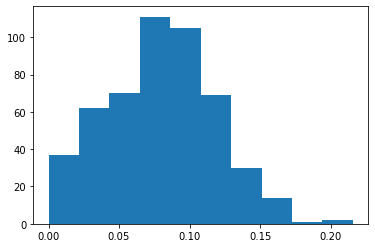

In [49]:
plt.hist(xx.std(dim='year'))

(array([ 37.,  62.,  70., 111., 105.,  69.,  30.,  14.,   1.,   2.]),
 array([1.93800130e-05, 2.15980985e-02, 4.31768170e-02, 6.47555354e-02,
        8.63342539e-02, 1.07912972e-01, 1.29491691e-01, 1.51070409e-01,
        1.72649128e-01, 1.94227846e-01, 2.15806565e-01]),
 <BarContainer object of 10 artists>)

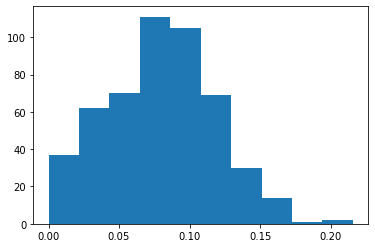

In [38]:
plt.hist(xx.std(dim='year'))

In [55]:
p0=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc')
pfts=xr.DataArray(np.array([str(p)[2:-1].strip() for p in p0.pftname[:17].values]),dims='pft')

In [6]:
def pval(ds,p,m=[]):
    d='/glade/campaign/asp/djk2120/PPEn11/paramfiles/'
    if p in m:
        pp=m[p]
    else:
        pp=p
    
    ix=ds.param==p
    keys=ds.key[ix]
    files=[d+k+'.nc' for k in keys.values]
    def preprocess(ds):
        return ds[pp]
    x=xr.open_mfdataset(files,combine='nested',concat_dim='ens',decode_times=False,
                        parallel=True,preprocess=preprocess)
    out=xr.Dataset()
    dims=list(x.dims)
    dims.remove('ens')
    if len(dims)>0:
        out['val']=xr.DataArray(x.mean(dim=dims).values,dims='ens')
    else:
        out['val']=xr.DataArray(x.values,dims='ens')
    out['ens']=ds.ens[ix]
    out['key']=keys
    out['param']=xr.DataArray(np.tile(p,ix.sum().values),dims='ens')
    return out

In [7]:
def nlval(ds,p):
    d='/glade/campaign/asp/djk2120/PPEn11/namelist_mods/'
    vals=[]
    ix=ds.param==p
    keys=ds.key[ix].values
    for k in keys:
        f=d+k+'.txt'
        with open(f) as file:
            lines = file.readlines()
        for line in lines:
            if p in line:
                v=float(line.split('=')[1].split('\n')[0])
                vals.append(v)
                break
    x=xr.Dataset()
    x['val']=xr.DataArray(vals,dims='ens')
    x['ens']=ds.ens[ix]
    x['key']=xr.DataArray(keys,dims='ens')
    x['param']=xr.DataArray(np.tile(p,ix.sum().values),dims='ens')
    return x

In [8]:
def get_pvals(ds):
    multis={'CWD':'cwd_fcel',
            'FR':'fr_flab',
            'LF':'lf_flab',
            'KCN':'kc_nonmyc',
            'Q10':'q10_hr'}
    p0=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc')
    params=list(np.unique(ds.param))
    for i in ['default','na']:
        if i in params:
            params.remove(i)
    xs=[]
    for p in params:
            if (p in multis)|(p in p0):
                x=pval(ds,p,m=multis)
            else:
                x=nlval(ds,p)
            xs.append(x)
    return xr.concat(xs,dim='ens').sortby('ens').compute()

In [9]:
def get_defp(ds):
    params=list(np.unique(ds.param))
    for i in ['default','na']:
        if i in params:
            params.remove(i)
    
    
    p0=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc',decode_times=False)
    lndin='/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
    
    multis={'CWD':'cwd_fcel',
        'FR':'fr_flab',
        'LF':'lf_flab',
        'KCN':'kc_nonmyc',
        'Q10':'q10_hr'}
    
    with open(lndin) as file:
        lines = file.readlines()
    
    p=np.array(params)[[param in p0 for param in params]]
    m=[multis[p] for p in multis]
    f=np.concatenate([p,m])
    n=np.array(params)[[param not in f for param in params]]
    
    nvals={}
    for line in lines:
        for v in n:
            if v in line:
                x=line.split('=')[1]
                if 'd' in x:
                    b=float(x.split('d')[0])
                    e=float(x.split('d')[1])
                    x=b*10**e
                else:
                    x=float(x)
                nvals[v]=x
                
    x1=xr.DataArray([p0[p].mean().values for p in p],dims='param')
    x1['param']=p
    x2=xr.DataArray([p0[p].mean().values for p in m],dims='param')
    x2['param']=[p for p in multis]
    x3=xr.DataArray([nvals[p] for p in nvals],dims='param')
    x3['param']=[p for p in nvals]
    out=xr.concat([x1,x2,x3],dim='param')
    
    return out
                
    

In [86]:
def get_surv(exp):
    d='/glade/campaign/asp/djk2120/PPEn11/'
    df=pd.read_csv(d+'csvs/surv.csv')
    keys = [k for k in df.key.values]
    files=[glob.glob(d+exp+'/hist/*'+k+'*h1*.nc')[0] for k in keys]
    lapft=xr.open_dataset('landarea_oaat.nc').landarea_pft
    appends={'key':xr.DataArray(keys,dims='ens'),
             'param':xr.DataArray(df.param.values,dims='ens'),
             'lapft':lapft}
    
    return files,appends

In [10]:
def get_files(exp):
    d='/glade/campaign/asp/djk2120/PPEn11/'
    files=sorted(glob.glob(d+exp+'/hist/*OAAT*h1*'))
    keys=['OAAT'+f.split('OAAT')[1].split('.')[0] for f in files]
    df=pd.read_csv(d+'csvs/oaat.csv')
    params=[]
    minmax=[]
    ix=[]
    for k in keys:
        p=df.param[df.key==k].values[0]
        m=df.minmax[df.key==k].values[0]
        if p!='test':
            params.append(p)
            minmax.append(m)
            ix.append(True)
        else:
            ix.append(False)

    files =np.array(files)[ix]
    keys=xr.DataArray(np.array(keys)[ix],dims='ens')
    params=xr.DataArray(params,dims='ens')
    lapft=xr.open_dataset('landarea_oaat.nc').landarea_pft
    appends={'key':keys,'param':params,'minmax':minmax,'lapft':lapft}
    return files,appends

In [33]:
def alive(ds,laithresh=0.1):
    a=(ds.lapft*(ds.TLAI.max(dim='time')>laithresh)).groupby('pft').sum().compute()
    return a

In [34]:
def surv(a,sthresh=0.7,default=0,lamin=1e3):
    ixpft=a.sel(ens=0)>lamin
    npft=ixpft.sum()
    s=(a/a.sel(ens=default)>0.7).isel(pft=ixpft).sum(dim='pft')==npft
    return s.compute()

In [35]:
def survtable(ds,p):
    ix=(ds.param==p)|(ds.param=='default')
    ds=ds.isel(ens=ix)
    a=alive(ds)
    s=surv(a)
    
    defp=get_defp(ds)
    pvals=get_pvals(ds)
    
    ix=(ds.param==p)|(ds.param=='default')
    ees=ds.ens[ix]
    vals=[defp.sel(param=p).values,*pvals.val.sel(ens=ees[1:]).values]
    d={'key':ds.key[ix],'surv':s[ix],p:vals}

    return pd.DataFrame(d)

In [36]:
def spair(p,ds,s,pvals,defp):
    ix=s&(ds.param==p)
    ees=ds.ens[ix]
    keys=ds.key[ix]
    vals=pvals.val.sel(ens=ees)
    vals=[defp.sel(param=p),*vals.values]
    keys=['OAAT0000',*keys.values]
    out=[keys[i] for i in (np.argmin(vals),np.argmax(vals))]
    return out

In [87]:
dsets={}
for exp in ['CTL2010','C285','AF1855']:
    files,appends=get_surv(exp)
    dsets[exp]=get_ds(files,['ens'],dvs=['TLAI'],appends=appends)


In [88]:
a={exp:alive(dsets[exp]) for exp in dsets}

In [89]:
ss={exp:surv(a[exp]) for exp in a}

In [90]:
s=ss['CTL2010']&ss['C285']&ss['AF1855']

In [91]:
ixpft=a['CTL2010'].sel(ens=0)>1e3
for ee in s.ens[~s]:
    k,p=(x.sel(ens=ee).values for x in (ds.key,ds.param))
    print(k,str(p).ljust(8))
    for exp in a:
        aa=(a[exp].sel(ens=ee)/a[exp].sel(ens=0)).compute()
        ix=(aa<0.7).isel(pft=ixpft)
        for pft in a[exp].pft.isel(pft=ixpft)[ix].values.astype(int):
            print(np.round(aa[pft].values,3),
                  exp.ljust(8),
                  pfts[pft].values)

OAAT0037 frac_sat_soil_dsl_init
0.582 C285     broadleaf_deciduous_temperate_shrub
OAAT0076 fff     
0.524 C285     broadleaf_deciduous_temperate_shrub
OAAT0376 tpuse_sf
0.698 CTL2010  broadleaf_deciduous_temperate_shrub
OAAT0403 jmaxb0  
0.498 C285     broadleaf_deciduous_temperate_shrub
OAAT0435 jmaxse_sf
0.698 CTL2010  broadleaf_deciduous_temperate_shrub
OAAT0442 vcmaxhd 
0.694 C285     broadleaf_deciduous_temperate_shrub


In [228]:
pvals=get_pvals(ds)
defp=get_defp(ds)

In [240]:
dsets={}
for exp in ['CTL2010','C285','AF1855']:
    files,appends=get_files(exp)
    dsets[exp]=get_ds(files,['ens'],dvs=['TLAI'],appends=appends)

In [241]:
a={exp:alive(dsets[exp]) for exp in dsets}

In [244]:
sd={exp:surv(a[exp]) for exp in a}

In [247]:
s=sd['CTL2010']&sd['C285']&sd['AF1855']

In [ ]:
#go through and flag if any surv keys are dead. let me know when/where
#go through and flag if any outsiders are alive.

In [250]:
params=list(np.unique(ds.param.values))
params.remove('default')
for p in params:
    if p in df.param.values:
        kk1=spair(p,ds,s,pvals,defp)
        ix=df.param==p
        kk2=df.key[ix].values
        match=True
        for k in kk2:
            if k in kk1:
                nmatch+=1
            else:
                match=False
        if not match:
            print(p,kk1,kk2)

            
    

FR ['OAAT0000', 'OAAT0384'] ['OAAT0383' 'OAAT0384']
LF ['OAAT0000', 'OAAT0382'] ['OAAT0381' 'OAAT0382']
aq_sp_yield_min ['OAAT0000', 'OAAT0000'] ['OAAT0075']
boreal_peatfire_c ['OAAT0315', 'OAAT0000'] ['OAAT0315' 'OAAT0316']
cn_s3_bgc ['OAAT0000', 'OAAT0000'] ['OAAT0271']
decomp_depth_efolding ['OAAT0000', 'OAAT0000'] ['OAAT0471']
fbw ['OAAT0169', 'OAAT0000'] ['OAAT0169' 'OAAT0170']
frac_sat_soil_dsl_init ['OAAT0000', 'OAAT0038'] ['OAAT0037' 'OAAT0038']
grperc ['OAAT0000', 'OAAT0178'] ['OAAT0177' 'OAAT0178']
jmaxb0 ['OAAT0415', 'OAAT0146'] ['OAAT0146' 'OAAT0403']
jmaxb1 ['OAAT0000', 'OAAT0148'] ['OAAT0147' 'OAAT0148']
jmaxse_sf ['OAAT0373', 'OAAT0000'] ['OAAT0373' 'OAAT0435']
kc25_coef ['OAAT0128', 'OAAT0000'] ['OAAT0128' 'OAAT0129']
medlynslope ['OAAT0400', 'OAAT0000'] ['OAAT0118' 'OAAT0400']
n_baseflow ['OAAT0000', 'OAAT0000'] ['OAAT0086']
nstem ['OAAT0171', 'OAAT0000'] ['OAAT0171' 'OAAT0172']
q10_mr ['OAAT0245', 'OAAT0246'] ['OAAT0246' 'OAAT0405']
rootprof_beta ['OAAT0478', 'OAAT016

In [239]:
survtable(ds,'q10_mr')

,key,surv,q10_mr
0,OAAT0000,True,1.5
1,OAAT0246,True,3.0
2,OAAT0245,True,1.0
3,OAAT0405,True,1.25
4,OAAT0417,True,1.375
5,OAAT0429,True,1.4375


In [233]:
defp.sel(param='FR')

<xarray.DataArray ()>
array(0.24683544)
Coordinates:
    param    <U32 'FR'

In [234]:
d='/glade/campaign/asp/djk2120/PPEn11/paramfiles/'
tmp=xr.open_dataset(d+'OAAT0000.nc')

In [236]:
tmp['fr_fcel']

<xarray.DataArray 'fr_fcel' (pft: 79)>
array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
Coordinates:
    pftname  (pft) |S40 b'not_vegetated                           ' ... b'irr...
Dimensions without coordinates: pft
Attributes:
    long_name:  Fine root litter cellulose fraction
    units:      fraction

In [165]:
survtable(ds,'hksat_sf')

,key,surv,hksat_sf
0,OAAT0000,True,1.0
1,OAAT0064,True,0.1
2,OAAT0065,True,10.0


In [161]:
ees=ds.ens[ds.param=='kmax']
pvals.val.sel(ens=ees)

<xarray.DataArray 'val' (ens: 2)>
array([2.26810127e-09, 3.79215190e-08])
Coordinates:
  * ens      (ens) int64 131 132

In [46]:
exp='CTL2010'
dvs=['TLAI']
files,appends=get_files(exp)
ds=get_ds(files,['ens'],dvs=dvs,appends=appends)

In [49]:
df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/surv.csv')

In [149]:
p='medlynintercept'
ix=df.param==p
print(df.key[ix].values)



['OAAT0119' 'OAAT0413']


,key,surv,medlynintercept
0,OAAT0000,True,100.0
1,OAAT0119,True,1.0
2,OAAT0120,False,200000.0
3,OAAT0401,False,100000.0
4,OAAT0413,True,50000.0
5,OAAT0425,True,25000.0
6,OAAT0436,True,12500.0
7,OAAT0437,True,6250.0
8,OAAT0438,True,3125.0


In [136]:
pvals.val.sel(ens=ees)

<xarray.DataArray 'val' (ens: 6)>
array([1.000e+00, 5.000e+04, 2.500e+04, 1.250e+04, 6.250e+03, 3.125e+03])
Coordinates:
  * ens      (ens) int64 341 403 415 426 427 428

In [6]:
p0=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc')
pfts=xr.DataArray(np.array([str(p)[2:-1].strip() for p in p0.pftname[:17].values]),dims='pft')


In [8]:
dvs=['TLAI']
dsets={}
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
for exp in exps:
    files,appends=get_files(exp)
    dsets[exp]=get_ds(files,['ens'],dvs=dvs,appends=appends)
ds=dsets['CTL2010']

In [11]:
la=xr.open_dataset('landarea_oaat.nc').landarea_pft

In [24]:
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
laimin=0.1
alives={exp:(la*(dsets[exp].TLAI.max(dim='time')>laimin)).groupby('pft').sum().compute()
        for exp in exps}

survs = {exp:alives[exp]/alives[exp].isel(ens=0)>0.7 for exp in exps}

In [31]:
surv=survs['CTL2010']
for exp in ['C285','AF1855']:
    surv=(surv)&(survs[exp])

In [9]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)

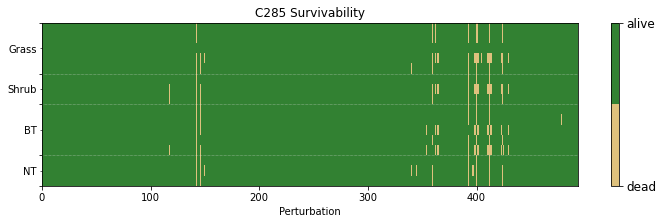

In [11]:
npix0=npix['C285'].isel(ens=0)
surv = ((npix['C285']/npix0)>surv_thresh).sel(pft=1+np.arange(16))

fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(surv.T,cmap=newcmp)


cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=12)

plt.yticks([0,3,8,11,16])
ax.set_yticks([1.5,5.5,9.5,13.5], minor=True)
for y in [3,8,11]:
    plt.plot([0,len(surv.ens)],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)
    
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','Shrub','Grass'],minor=True);
plt.xlabel('Perturbation')
plt.title('C285 Survivability');

In [38]:
params=list(np.unique(ds.param.values))
params.remove('default')
params.remove('na')
x0=defp(params)
x=pvals(params,ds)

In [43]:
ixpft=alives['CTL2010'].isel(ens=0)>1e3
s=np.array([surv.isel(ens=(ds.key==k).values,pft=ixpft).sum(dim='pft')==15 for k in x.key]).ravel()

In [44]:
out={}
for p in params:
    ix=(x.param==p)&(s)
    if ix.sum()>0:
        i=x.val[ix].argmin()
        v=x.val[ix].min()
        k=str(x.key[ix][i].values)
        if v<x0.sel(param=p):
            out[k]=(p,'min')

        a=x.val[ix].argmax()
        v=x.val[ix].max()
        k=str(x.key[ix][a].values)
        if v>x0.sel(param=p):
            out[k]=(p,'max')    


In [46]:
keys=np.sort([k for k in out])
f = open("surv2.csv", "w")
f.write('key,param,minmax\n')
for k in keys:
    f.write(k+','+out[k][0]+','+out[k][1]+'\n')
f.close()

In [47]:
df1=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/surv.csv')
df2=pd.read_csv('surv2.csv')

In [50]:
d='/glade/campaign/asp/djk2120/PPEn11/CTL2010/hist/'

In [64]:
k='OAAT0000'
f0=glob.glob(d+'*'+k+'*h0*')[0]
t0=xr.open_dataset(f0).TLAI

In [75]:
for k in keys:
    f=glob.glob(d+'*'+k+'*h0*')[0]
    t=xr.open_dataset(f).TLAI

    if t.equals(t0):
        print(k)

In [74]:
t.equals(t0)

False

In [68]:
t0

<xarray.DataArray 'TLAI' (time: 120, gridcell: 400)>
array([[4.143265, 3.213712, 6.993703, ..., 0.      , 0.      , 0.      ],
       [4.172805, 3.229918, 7.017825, ..., 0.      , 0.      , 0.      ],
       [2.596615, 2.313792, 5.715181, ..., 0.      , 0.      , 0.      ],
       ...,
       [4.154158, 2.195215, 7.010916, ..., 0.      , 0.      , 0.      ],
       [4.131024, 3.206635, 6.986259, ..., 0.      , 0.      , 0.      ],
       [4.126234, 3.204277, 6.980705, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [67]:
t

<xarray.DataArray 'TLAI' (time: 120, gridcell: 400)>
array([[4.143477, 3.213071, 6.993662, ..., 0.      , 0.      , 0.      ],
       [4.173021, 3.22928 , 7.017783, ..., 0.      , 0.      , 0.      ],
       [2.596758, 2.313448, 5.715147, ..., 0.      , 0.      , 0.      ],
       ...,
       [4.154477, 2.200145, 7.010931, ..., 0.      , 0.      , 0.      ],
       [4.131344, 3.206276, 6.986273, ..., 0.      , 0.      , 0.      ],
       [4.126556, 3.2039  , 6.980719, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [48]:
for p in params:
    out1={}
    out2={}
    for m in ['min','max']:
        ix=(df1.param==p)&(df1.minmax==m)
        if ix.sum()>0:
            out1[m]=df1.key[ix].values[0]
        ix=(df2.param==p)&(df2.minmax==m)
        if ix.sum()>0:
            out2[m]=df2.key[ix].values[0]
    if not out1==out2:
        print(p)
        print(out1)
        print(out2)

CWD
{'min': 'OAAT0387', 'max': 'OAAT0388'}
{}
FR
{'min': 'OAAT0383', 'max': 'OAAT0384'}
{}
KCN
{'min': 'OAAT0379', 'max': 'OAAT0380'}
{}
LF
{'min': 'OAAT0381', 'max': 'OAAT0382'}
{}
Q10
{'min': 'OAAT0385', 'max': 'OAAT0386'}
{}
a_fix
{}
{'min': 'OAAT0483', 'max': 'OAAT0484'}
act25
{}
{'min': 'OAAT0135', 'max': 'OAAT0136'}
aq_sp_yield_min
{'min': 'OAAT0075'}
{}
b_fix
{}
{'min': 'OAAT0485', 'max': 'OAAT0486'}
bdnr
{}
{'min': 'OAAT0507', 'max': 'OAAT0508'}
boreal_peatfire_c
{'min': 'OAAT0315', 'max': 'OAAT0316'}
{'min': 'OAAT0315'}
bsw_sf
{}
{'min': 'OAAT0062', 'max': 'OAAT0063'}
c_fix
{}
{'min': 'OAAT0487', 'max': 'OAAT0488'}
cn_s3_bgc
{'max': 'OAAT0271'}
{}
crit_dayl
{}
{'min': 'OAAT0493', 'max': 'OAAT0494'}
crit_offset_fdd
{}
{'min': 'OAAT0495', 'max': 'OAAT0496'}
crit_offset_swi
{}
{'min': 'OAAT0497', 'max': 'OAAT0498'}
crit_onset_gdd_sf
{}
{'min': 'OAAT0491', 'max': 'OAAT0492'}
crit_onset_swi
{}
{'min': 'OAAT0499', 'max': 'OAAT0500'}
dbh
{}
{'min': 'OAAT0464', 'max': 'OAAT0465'}
deco

In [251]:
out1

{}

In [252]:
out2

{'min': 'OAAT0507', 'max': 'OAAT0508'}

In [165]:
p0=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc')
pfts=xr.DataArray(np.array([str(p)[2:-1].strip() for p in p0.pftname[1:17].values]),dims='pft')
pfts['pft']=1+np.arange(16)

In [211]:
p='lmrhd'

ix=(ds.param==p).values
for k in ds.key[ix].values:
    v=np.round(x.val[x.key==k].values[0],2)
    alive=True
    for exp in ['CTL2010','C285','C867']:
        ix2=(ds.key==k).values
        s=survs[exp].isel(ens=ix2).sel(pft=1+np.arange(16)).values.ravel()
        if s.sum()<16:
            print(k,v,exp,pfts[~s].values)
            alive=False
    if alive:
        print(k,v,'cool')
            

OAAT0370 225975.0 cool
OAAT0369 75325.0 CTL2010 ['needleleaf_evergreen_temperate_tree' 'needleleaf_evergreen_boreal_tree'
 'broadleaf_evergreen_shrub' 'broadleaf_deciduous_temperate_shrub'
 'c3_non-arctic_grass' 'c3_crop' 'c3_irrigated']
OAAT0409 112987.5 CTL2010 ['needleleaf_evergreen_temperate_tree' 'needleleaf_evergreen_boreal_tree'
 'needleleaf_deciduous_boreal_tree' 'broadleaf_evergreen_temperate_tree'
 'broadleaf_deciduous_temperate_tree' 'broadleaf_deciduous_boreal_tree'
 'broadleaf_evergreen_shrub' 'broadleaf_deciduous_temperate_shrub'
 'broadleaf_deciduous_boreal_shrub' 'c3_arctic_grass'
 'c3_non-arctic_grass' 'c3_crop' 'c3_irrigated']
OAAT0409 112987.5 C285 ['needleleaf_evergreen_temperate_tree' 'needleleaf_evergreen_boreal_tree'
 'needleleaf_deciduous_boreal_tree' 'broadleaf_evergreen_temperate_tree'
 'broadleaf_deciduous_temperate_tree' 'broadleaf_deciduous_boreal_tree'
 'broadleaf_evergreen_shrub' 'broadleaf_deciduous_temperate_shrub'
 'broadleaf_deciduous_boreal_shrub' 'c

In [124]:
nx=np.array([(x.param==p).sum() for p in params])
np.array(params)[nx.argsort()[-10:]]

array(['medlynslope', 'jmaxb0', 'wc2wjb0', 'jmaxse_sf', 'rootprof_beta',
       'vcmaxse_sf', 'medlynintercept', 'vcmaxhd', 'lmrhd', 'sucsat_sf'],
      dtype='<U32')

In [86]:
npix['CTL2010'].isel(ens=0)

<xarray.DataArray 'TLAI' (pft: 17)>
array([  0, 133, 138,  99, 116,  70, 109, 126, 114,   7, 150, 114, 120,
       229, 159, 279, 143])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 12.0 13.0 14.0 15.0 16.0

In [85]:
npix['CTL2010'].isel(ens=(ds.param==p).values)

<xarray.DataArray 'TLAI' (ens: 8, pft: 17)>
array([[  0, 133, 137,  99, 116,  70, 109, 127, 114,   7, 150, 114, 120,
        229, 159, 279, 143],
       [  0, 132, 137,  95,  82,  50, 100,  94,  86,   7, 137, 110, 117,
        211, 164, 278, 143],
       [  0, 133, 139,  97, 101,  60, 103, 106,  93,   7, 140, 112, 121,
        219, 165, 278, 143],
       [  0, 135, 139,  99, 109,  66, 107, 113, 100,   7, 151, 112, 118,
        224, 162, 278, 143],
       [  0, 134, 138,  99, 113,  68, 107, 115, 103,   7, 152, 113, 124,
        231, 161, 279, 143],
       [  0, 134, 139,  99, 115,  69, 109, 121, 111,   7, 152, 114, 124,
        231, 157, 279, 143],
       [  0, 133, 138,  99, 116,  70, 109, 122, 112,   7, 153, 114, 124,
        231, 157, 279, 143],
       [  0, 133, 138,  99, 116,  70, 109, 124, 114,   7, 152, 114, 124,
        229, 158, 279, 143]])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 12.0 13.0 14.0 15.0 16.0
Dimensions without coordinates: ens

In [47]:
ix2=np.array([surv.isel(ens=(ds.key==k).values,pft=ixpft).sum()==15 for k in keys])


array([False, False,  True,  True,  True])

In [41]:
s

<xarray.DataArray 'TLAI' ()>
array(True)

In [214]:
5+5

10

In [217]:
surv_thresh=0.5
survs={exp:npix[exp]/npix[exp].sel(ens=0)>surv_thresh for exp in npix}
npix['C285'][ixk,ixp][1,:]

<xarray.DataArray 'TLAI' (pft: 15)>
array([125,  44,  79, 115,  64, 109, 129, 104, 149,  95,  78, 222, 170,
       271, 142])
Coordinates:
  * pft      (pft) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 12.0 13.0 14.0 15.0 16.0

In [221]:
npix['C285'].isel(ens=0)

<xarray.DataArray 'TLAI' (pft: 17)>
array([  0, 130, 133,  98, 113,  69, 106, 112, 102,   7, 135, 114, 118,
       210, 169, 279, 143])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 12.0 13.0 14.0 15.0 16.0

In [185]:
df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/surv.csv')

In [187]:
df.key[df.param==p]

107    OAAT0118
354    OAAT0400
Name: key, dtype: object

In [184]:
s

<xarray.DataArray 'TLAI' (ens: 5)>
array([False, False,  True,  True,  True])
Dimensions without coordinates: ens

In [183]:
vals

<xarray.DataArray 'val' (ens: 5)>
array([3.17265823, 6.93405063, 3.23594936, 3.26759493, 3.28341772])
Coordinates:
  * ens      (ens) int64 339 340 390 402 414
Attributes:
    long_name:  Constant for liquid water grain growth [m3 s-1],from Brun89: ...
    units:      m3/s

In [182]:
keys

<xarray.DataArray 'key' (ens: 5)>
array(['OAAT0117', 'OAAT0118', 'OAAT0400', 'OAAT0412', 'OAAT0424'],
      dtype='<U8')
Coordinates:
  * ens      (ens) int64 339 340 390 402 414

In [181]:
x0.sel(param='medlynslope')

<xarray.DataArray ()>
array(4.8403797)
Coordinates:
    param    <U32 'medlynslope'

In [180]:
vals[ixs]

<xarray.DataArray 'val' (ens: 3)>
array([3.23594936, 3.26759493, 3.28341772])
Coordinates:
  * ens      (ens) int64 390 402 414
Attributes:
    long_name:  Constant for liquid water grain growth [m3 s-1],from Brun89: ...
    units:      m3/s

In [104]:
#ignore bareground and 
ixp=npix['CTL2010'].sel(ens=0)>10

In [108]:
p='medlynslope'
surv


<xarray.DataArray 'TLAI' (ens: 493, pft: 16)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * pft      (pft) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 12.0 13.0 14.0 15.0 16.0
Dimensions without coordinates: ens

In [90]:

x3

<xarray.DataArray (param: 20)>
array([1.00e+00, 5.00e-02, 1.00e-03, 1.70e-01, 5.00e-01, 1.17e-02,
       6.00e-04, 1.75e+02, 8.30e-07, 1.70e-04, 2.80e-01, 5.00e-01,
       1.60e-04, 7.50e+01, 1.70e-04, 3.30e-01, 1.00e-02, 8.00e+01,
       3.00e+01, 1.05e+03])
Coordinates:
  * param    (param) <U28 'interception_fraction' ... 'ufuel'

In [18]:
params=list(np.unique(ds.param))
params.remove('default')
params.remove('na')

In [19]:
xs=[pvals(p) for p in params]

In [20]:
x=xr.concat(xs,dim='ens').sortby('ens')

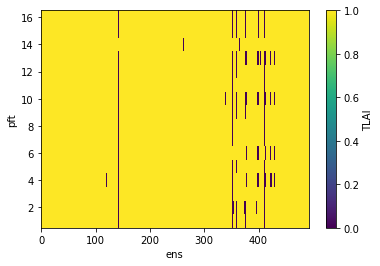

In [36]:
surv_thresh=0.7
surv=npix['CTL2010']>-1
for exp in npix:
    surv=surv&(npix[exp]/npix[exp].sel(ens=0)>surv_thresh)
    
surv=surv.sel(pft=1+np.arange(16))
surv.T.plot()

In [39]:
p='medlynslope'
ix=x.param==p
vals=x.val[ix]
keys=x.key[ix]
ees=x.ens[ix]
s=surv.sel(ens=ees).sum(dim='pft')
ees[s==16]




<xarray.DataArray 'ens' (ens: 3)>
array([390, 402, 414])
Coordinates:
  * ens      (ens) int64 390 402 414